In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np

## Load data
Preprocess to chunks

In [13]:
import json
from nltk import word_tokenize

with open('../data/partijen-metadata.json', 'r') as f:
     meta = json.load(f)

party_dict = {}
for party_data in meta['partijen']:
    party_id = party_data['lijst']
    party_name = party_data['naam'].encode('utf-8')
    party_dict["{:02d}".format(party_id)] = party_name
    
raw = pd.read_csv('../data/processed/dataframe.csv') 
raw['file'] = raw['file'].replace(to_replace=party_dict, regex=True).apply(lambda x: x.split('-')[1])
raw.rename(columns={'file': 'party'}, inplace=True)

party_labels = raw['party']
n_parties = len(party_labels)

def chunk_string(string, chunk_size=1000, overlap=0):
    return [string[i:i+chunk_size-overlap+1] for i in xrange(0,len(string), chunk_size-overlap)]
   # return [string[0+i:length+i] for i in range(0, len(string), length)]

df = raw['text'].apply(lambda x: pd.Series(chunk_string(x, chunk_size=600, overlap=0))).stack().reset_index()
df.rename(columns={0: 'text', 'level_0': 'party', 'level_1': 'snippet'}, inplace=True)

print "{:d} text snippets".format(len(df))
print "{:d} charachters in corpus".format(df['text'].apply(len).sum())
print "{:d} words in corpus".format(df['text'].apply(lambda x: word_tokenize(x, language='dutch')).apply(len).sum())
df.head()

4897 text snippets
2936241 charachters in corpus
419590 words in corpus


,party,snippet,text
0,0,0,n e d n o b r e v n ee g n i v e l sa m e n ve...
1,0,1,twerp paul pollmann inhoudsopgave essay ee...
2,0,2,rismebestrijding privacy justitie en rechtstaa...
3,0,3,ing werk en gezin pensioenen werkende ouderen ...
4,0,4,iedereen publieke waarden centraal van marktw...


In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import TruncatedSVD #, NMF
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
from nltk.stem.snowball import DutchStemmer

stemmer = DutchStemmer()
def tokenize(text):
    """Converts text to tokens."""
    tokens = word_tokenize(text, language='dutch')
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

n_topics = 100

preproc_steps = [('vectorizer', TfidfVectorizer(input='content', encoding='utf-8',
                                                decode_error='strict', strip_accents='unicode',
                                                lowercase=True, preprocessor=None, tokenizer=tokenize,
                                                analyzer='word', stop_words=stopwords.words('dutch'), 
                                                ngram_range=(1, 3), max_df=0.5, min_df=1, max_features=1000000,
                                                vocabulary=None, binary=False, dtype=np.int64,
                                                norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)),
                 
                 ('topic_model', TruncatedSVD(n_components=n_topics, algorithm='arpack', n_iter=10, random_state=12, tol=0.0))]
                
#                 ('topic_model', NMF(n_components=n_topics, init='nndsvd', solver='cd', tol=0.0001, max_iter=200, random_state=42, 
#                                     alpha=0.0, l1_ratio=0.0, verbose=0, shuffle=False, nls_max_iter=2000, 
#                                     sparseness=None, beta=1, eta=0.1))]

# balanced priors for Naive Bayes
equal_priors = np.ones(n_parties) /  np.float64(n_parties)
equal_priors[0] = equal_priors[0] + (1 - equal_priors.sum())

# specification of different model types and their defaults
model_steps_dict = {'nb': [('nb', GaussianNB(priors=equal_priors))],
                    'rf': [('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=32))],
                    'lr': [('lr', LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='lbfgs'))],
                    'tree': [('tree', DecisionTreeClassifier(class_weight='balanced', random_state=32, max_depth=10))],
                   'dummy': [('dummy', DummyClassifier(strategy='prior', random_state=11))]}

# extract data from data frame
X = df['text'].values 
y = np.array(df['party'])

def build_estimator(model_type):
    model_steps = model_steps_dict[model_type]
    estimator = Pipeline(steps=(preproc_steps + model_steps))
    return estimator

evaluate = True
if evaluate:
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=1)
    for model_type in ['lr','dummy']: # model_steps_dict.keys():
        estimator = build_estimator(model_type)
        scores = cross_val_score(estimator, X, y, cv=cv)
        print "Average {:s} classifier score: {:.4f} ".format(model_type, np.mean(scores))

Average lr classifier score: 0.5204 
Average dummy classifier score: 0.1388 


In [15]:
# fit on whole data set
model_type = 'lr'
estimator = build_estimator(model_type)
estimator.fit(X, y)
estimator

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=1000000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=...',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False))])

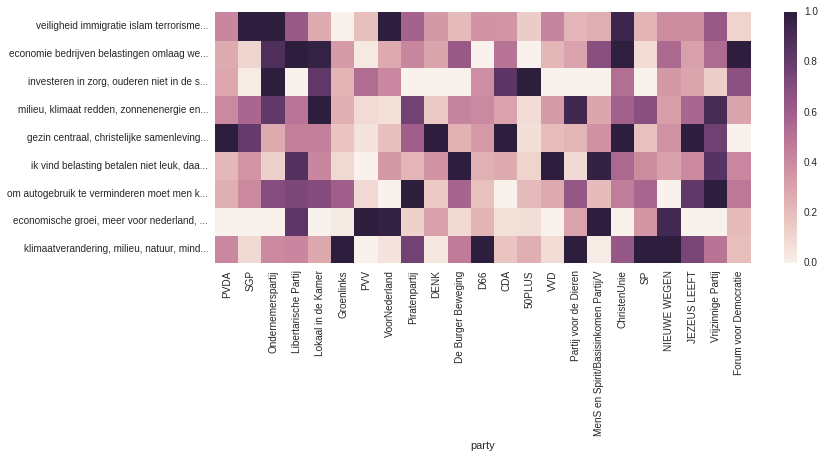

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_predictions(results):
    figsize=(12, .5 * len(results))
    fig, ax = plt.subplots(figsize=figsize)   
    sns.heatmap(results, ax=ax)
    ax.set_ylabel('')
    
def classify_text(estimator, texts, norm=None):
    pred_proba = estimator.predict_proba(texts)
    capped_texts = map(lambda x: x[:40] + '...', texts)
    results = pd.DataFrame(pred_proba, columns=[party_labels], index=capped_texts)
    if norm=='rank':
        results = results.rank(axis=1, ascending=True)
    if norm=='range':
        results = results.apply(lambda x: (x - x.min()) / (x.max()- x.min()), axis=0)
    if norm=='top3':
        results = results.rank(axis=1, ascending=True).applymap(lambda x: n_parties-3 if x<=(n_parties-3) else x)
    plot_predictions(results)

texts = ['veiligheid immigratie islam terrorisme',
         
         'economie bedrijven belastingen omlaag werkgelegenheid',
         
         'investeren in zorg, ouderen niet in de steek laten, pensioenen verhogen, pensioensleeftijd terug naar 65',
    
         'milieu, klimaat redden, zonnenenergie en windmolens, volledig overstappen naar duurzame energie, \
         CO2-tax invoeren, milieubelasting (alleen voor bedrijven dan graag)',
         
         'gezin centraal, christelijke samenleving, landbouwsubsidies, samen kun je meer, alleen sta je zwak',
         
         'ik vind belasting betalen niet leuk, daarom graag minder belasting \
         ik wil ook graag goedkoop auto rijden, bovendien moet werken lonen',
         
         'om autogebruik te verminderen moet men kilometerheffing invoeren, de vervuiler betaalt, daarnaast moet men het \
         openbaar vervoer stimuleren, de natuur moet beschermt worden via mileuheffingen',
        
         'economische groei, meer voor nederland, Nederlanders moeten vooruit, gulden, \
            meer geld, meer rijkdom, industrie, geen IS, allochtenen weg', 
         
         'klimaatverandering, milieu, natuur, minder consumeren, nieuwe technologie, \
            duurzaam, openbaar vervoer, intelligentie, intelligente oplossingen, samenwerken in europa']

classify_text(estimator, texts, norm='range')

In [6]:
# function for multilabel format
def extract_probas(pred_proba):
    return np.array(map(lambda x1: map(lambda x2: x2[1], x1), pred_proba)).transpose()